In [1]:
import os
import pandas as pd
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

import scienceplots
plt.style.use(['science', 'no-latex'])
plt.rc('text', usetex=True)

from src.plots import set_size

df_dict = defaultdict(dict)
LOGDIR = 'logs_tokenizer'

# key_extractor = lambda x: x.split('_')[1:]

for subfolder in os.listdir(LOGDIR):
    subfolder_path = os.path.join(LOGDIR, subfolder)
    csv_file_path = os.path.join(subfolder_path, 'version_0', 'metrics.csv')
    if os.path.exists(csv_file_path):
        df = pd.read_csv(csv_file_path)
        tokenizer = subfolder.split('_')[1]
        vocab = subfolder.split('_')[2]
        df_dict[tokenizer][vocab] = df

In [2]:
def extract_metric_values(df_dict, metric_name, operation='last'):
    """
    Extracts specified metric values (either last or max) from nested DataFrames in df_dict.
    
    Parameters:
        df_dict (defaultdict(dict)): Nested dictionary of DataFrames keyed by tokenizer and vocab_size.
        metric_name (str): The name of the metric to extract.
        operation (str): The operation to perform ('last' or 'max').
        
    Returns:
        DataFrame: DataFrame containing the extracted metric values, indexed by vocab_size and columns by tokenizer.
    """
    # Initialize an empty dictionary to temporarily store the extracted values
    extracted_values_temp = defaultdict(dict)
    
    # Loop through the nested DataFrames
    for tokenizer, inner_dict in df_dict.items():
        if tokenizer == "bpe":
            tokenizer = "BPE"
        else:
            tokenizer = tokenizer.capitalize()
        for vocab_size, df in inner_dict.items():
            if metric_name in df.columns:
                if operation == 'last':
                    # Extract the last value of the specified metric
                    last_value = df[metric_name].dropna().iloc[-1]
                    extracted_values_temp[tokenizer][int(vocab_size)] = last_value
                    
                elif operation == 'max':
                    # Extract the maximum value of the specified metric
                    max_value = df[metric_name].dropna().max()
                    extracted_values_temp[tokenizer][int(vocab_size)] = max_value
                else:
                    print(f"Invalid operation '{operation}' specified. Skipping {tokenizer}, {vocab_size}.")
            else:
                print(f"Metric '{metric_name}' not found in DataFrame for {tokenizer}, {vocab_size}. Skipping.")
                
    # Convert the nested dictionary to a DataFrame
    extracted_values_df = pd.DataFrame.from_dict(extracted_values_temp, orient='index').transpose()
    
    # sort index by vocab_size
    extracted_values_df.sort_index(inplace=True)

    return extracted_values_df


In [3]:
df = extract_metric_values(df_dict, 'val_f1', operation='last')
# remove first row from df
# df = df.iloc[1:]
df

,BPE,Whitespace,Wordpunct
256,0.946619,0.776393,0.890948
512,0.939350,0.839502,0.918446
1024,0.943078,0.932076,0.955470
2048,0.948693,0.892413,0.964888
4096,0.953946,0.941664,0.963349
8192,0.984543,0.880652,0.974628
16384,0.992626,0.937493,0.986553


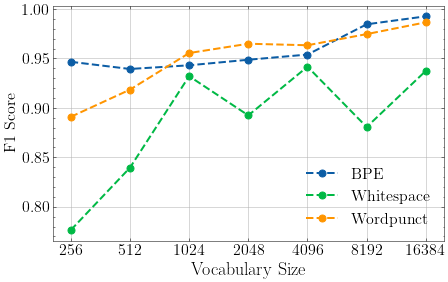

In [4]:
# Line Plot
fig, ax = plt.subplots(figsize=set_size())
for column in df.columns:
    ax.plot(df.index, df[column], marker='o', markersize=7, linestyle='--', linewidth=2, label=column)
    

# legend with 16 fontsize
ax.legend(fontsize=16)
ax.set_xlabel('Vocabulary Size', fontsize=18)
ax.set_ylabel('F1 Score', fontsize=16)
ax.set_xscale('log', base=2)
# ax.set_title('Line Plot of TPR Dependency on Tokenizer and Vocabulary')

# set xticks and xticklabels to be from df.index
ax.set_xticks(df.index)
ax.set_xticklabels(df.index, fontsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid()

# save figure to img/ as pdf
fig.savefig('img/tokenizer_vocabsize_f1.pdf', bbox_inches='tight', dpi=300)

In [5]:
df = extract_metric_values(df_dict, 'val_tpr', operation='last')
# remove first row from df
#df = df.iloc[1:]
df

,BPE,Whitespace,Wordpunct
256,0.861979,0.448789,0.740523
512,0.859946,0.574207,0.818898
1024,0.874943,0.550773,0.873149
2048,0.872609,0.640295,0.887505
4096,0.878656,0.696231,0.907435
8192,0.934434,0.583247,0.889084
16384,0.951120,0.653043,0.903022


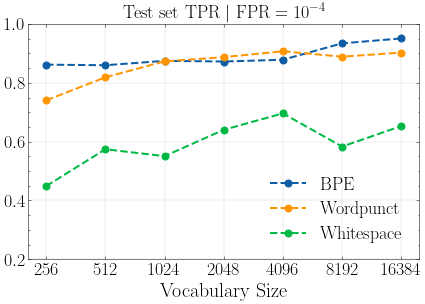

In [7]:
# Line Plot
fig, ax = plt.subplots(figsize=set_size())
for column in df.columns:
    ax.plot(df.index, df[column], marker='o', markersize=7, linestyle='--', linewidth=2, label=column)

ax.set_xlabel('Vocabulary Size', fontsize=20)
ax.set_title(r'Test set $\text{TPR}~|~\text{FPR} = 10^{-4}$', fontsize=18)
ax.set_xscale('log', base=2)
# ax.set_title('Line Plot of TPR Dependency on Tokenizer and Vocabulary')

# legend with 16 fontsize and three columns with title "Tokenizer"
handles, labels = ax.get_legend_handles_labels()
newhandles = [handles[0], handles[2], handles[1]]
newlabels = [labels[0], labels[2], labels[1]]
ax.legend(newhandles, newlabels, fontsize=18)#, title='Tokenizer:', title_fontsize=18)

# set xticks and xticklabels to be from df.index
ax.set_xticks(df.index, fontsize=18)
ax.set_xticklabels(df.index, fontsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.grid(linewidth=0.2)
ax.set_ylim(0.2, 1.0)

# save figure to img/ as pdf
fig.savefig('img/tokenizer_vocabsize_tpr.pdf', bbox_inches='tight', dpi=300)